# 영업 성공 여부 분류 경진대회

In [432]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. 데이터 확인

### 필수 라이브러리

In [433]:
import pandas as pd
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

### 데이터 셋 읽어오기

In [434]:
df_train = pd.read_csv("/content/drive/MyDrive/LGaimers/train.csv") # 학습용 데이터
df_test = pd.read_csv("/content/drive/MyDrive/LGaimers/submission.csv") # 테스트 데이터(제출파일의 데이터)

In [435]:
df_train.head() # 학습용 데이터 살펴보기

,bant_submit,customer_country,business_unit,com_reg_ver_win_rate,customer_idx,customer_type,enterprise,historical_existing_cnt,id_strategic_ver,it_strategic_ver,...,response_corporate,expected_timeline,ver_cus,ver_pro,ver_win_rate_x,ver_win_ratio_per_bu,business_area,business_subarea,lead_owner,is_converted
0,1.0,/Quezon City/Philippines,AS,0.066667,32160,End-Customer,Enterprise,NaN,NaN,NaN,...,LGEPH,less than 3 months,1,0,0.003079,0.026846,corporate / office,Engineering,0,True
1,1.0,/PH-00/Philippines,AS,0.066667,23122,End-Customer,Enterprise,12.0,NaN,NaN,...,LGEPH,less than 3 months,1,0,0.003079,0.026846,corporate / office,Advertising,1,True
2,1.0,/Kolkata /India,AS,0.088889,1755,End-Customer,Enterprise,144.0,NaN,NaN,...,LGEIL,less than 3 months,1,0,0.003079,0.026846,corporate / office,Construction,2,True
3,1.0,/Bhubaneswar/India,AS,0.088889,4919,End-Customer,Enterprise,NaN,NaN,NaN,...,LGEIL,less than 3 months,1,0,0.003079,0.026846,corporate / office,IT/Software,3,True
4,1.0,/Hyderabad/India,AS,0.088889,17126,Specifier/ Influencer,Enterprise,NaN,NaN,NaN,...,LGEIL,less than 3 months,0,0,0.003079,0.026846,corporate / office,NaN,4,True


## 2. 데이터 전처리

### 2.1데이터 전처리

중복 제거

In [436]:
df_train.drop_duplicates(inplace=True)

####1.[bant_submit]
그냥 Object화 시키고 싶음 그게 그냥 Label encode인가

####2. [customer_country]
'/' 기준 나라만 쏙 빼오기

In [437]:
import numpy as np
import pandas as pd

# 'customer_country' 컬럼에서 나라 이름을 추출하는 함수
def extract_country_name(x):
    if pd.isnull(x):
        return 0
    else:
        a = x.split("/")
        return a[-1]

# 'customer_country' 컬럼에서 0값을 최빈값 상위 10개의 나라로 랜덤하게 채우는 함수
def fill_zero_with_top_countries(df):
    # 'customer_country'가 0인 행의 인덱스를 찾습니다.
    index_0 = df[df['customer_country'] == 0].index

    # 'customer_country'의 최빈값 상위 10개를 비율대로 랜덤하게 선택합니다.
    top10_countries = df['customer_country'].value_counts().head(10)
    top10_countries_prob = top10_countries / top10_countries.sum()

    # 랜덤하게 선택한 나라로 0값을 채웁니다.
    df.loc[index_0, 'customer_country'] = np.random.choice(top10_countries.index, size=len(index_0), p=top10_countries_prob)

# 'customer_country' 컬럼에서 나라 이름을 추출합니다.
df_train["customer_country"] = df_train["customer_country"].apply(extract_country_name)
df_test["customer_country"] = df_test["customer_country"].apply(extract_country_name)
df_train["customer_country.1"]=df_train["customer_country.1"].apply(extract_country_name)
df_test["customer_country.1"]=df_test["customer_country.1"].apply(extract_country_name)

# 'customer_country' 컬럼에서 0값을 최빈값 상위 10개의 나라로 랜덤하게 채웁니다.
fill_zero_with_top_countries(df_train)
fill_zero_with_top_countries(df_test)


####3.[business_unit]
AS,ID,IT만 가져가고 나머진 짤라

In [438]:
df_train = df_train[df_train['business_unit'].isin(['AS', 'ID', 'IT'])]
df_test = df_test[df_test['business_unit'].isin(['AS', 'ID', 'IT'])]


#### 4.[com_reg_ver_win_rate]
어케할지 몰라 보류

In [439]:
#로그변환
df_train['com_reg_ver_win_rate'] = np.log1p(df_train['com_reg_ver_win_rate'])
df_test['com_reg_ver_win_rate'] = np.log1p(df_test['com_reg_ver_win_rate'])



####5 [customer_idx]
25096이 무조건 'is_converted'값이 True임 하지만 test_data에는 없음
고로 컷!

id =47466이 가장 많이 나옴. test에서도 동일한 분포
고로, 47466 기준으로 이진분류.

In [440]:
del_id=[25096]
df_train=df_train[~df_train["customer_idx"].isin(del_id)]
df_train = df_train[(df_train["business_unit"] != "CM") & (df_train["business_unit"] != "Solution")]

In [441]:
def change_value(x):
    if x == 47466:
        return 1
    else:
        return 0

df_train['customer_idx'] = df_train['customer_idx'].apply(change_value)
df_test['customer_idx'] = df_test['customer_idx'].apply(change_value)



####6[customer_type]
상위 3개 아니면 others로 변경

In [442]:
def preprocess_customer_type(x):
    if x == 'End-Customer' :
        return 'End Customer'
    elif x == 'Specifier/ Influencer' :
        return 'Specifier / Influencer'
    elif x =='Other' or x=='Others':
        return 'Etc.'
    elif x == 'Software/Soultion Provider' :
        return 'Software / Solution Provider'
    else:
        return x

df_train['customer_type'] = df_train['customer_type'].apply(preprocess_customer_type)
df_test['customer_type'] = df_test['customer_type'].apply(preprocess_customer_type)

In [443]:
def preprocess_customer_type(df):
    # 'End-Customer'를 'End Customer'로 변경
    df['customer_type'] = df['customer_type'].replace('End-Customer', 'End Customer')

    # 가장 많이 나오는 변수 상위 3개를 저장
    top3_types = df['customer_type'].value_counts().index[:3]

    # 상위 3개에 속하지 않는 경우 'others'로 변경
    df['customer_type'] = df['customer_type'].apply(lambda x: x if x in top3_types else 'others')

    return df

# 함수를 훈련 데이터와 테스트 데이터에 적용
df_train = preprocess_customer_type(df_train)
df_test = preprocess_customer_type(df_test)


####7[historical_existing_cnt]

ㅈㄴ 중요해보임
떠오르는 방안은 2가지
1. 4를 기준으로 단골 손님  or 그냥 손님으로 나누냐

2. 예측을 해서 결측값을 채워 넣을까
->로그 변환은 필요해 보인다
---


####8[id, it, idit]
 'id_strategic_ver', 'it_strategic_ver' 열을 삭제
 아래 drop_columns에서 삭제열 추가.

In [444]:
# df_train = df_train.drop(['id_strategic_ver', 'it_strategic_ver'], axis=1)
# df_test = df_test.drop(['id_strategic_ver', 'it_strategic_ver'], axis=1)
df_train['idit_strategic_ver'] = df_train['idit_strategic_ver'].fillna(0)
df_test['idit_strategic_ver'] = df_test['idit_strategic_ver'].fillna(0)

####9[customer_job]
걍 label?

####10[lead_desc_length]
진짜 ㅁㄹ겠음
min max sclaer 하고 정보를 제공한 비율인 length_ratio 만듦

In [445]:
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
scaler = MinMaxScaler()

# 'lead_desc_length' 열에 대해 MinMaxScaler를 적용하고, 결과를 새로운 열에 저장
df_train['lead_desc_length'] = scaler.fit_transform(df_train[['lead_desc_length']])
df_test['lead_desc_length'] = scaler.fit_transform(df_test[['lead_desc_length']])

####11[inquiry_type]
원핫 인코딩

In [446]:
import pandas as pd

import pandas as pd

def modify_variables(dataframe):
    # 모든 변수를 소문자로 변환
    dataframe['inquiry_type'] = dataframe['inquiry_type'].str.lower()

    # 'inquiry_type' 열의 상위 4개 값을 추출
    top_3_values = dataframe['inquiry_type'].value_counts().head(9).index.tolist()

    # 'inquiry_type' 열의 값이 상위 4개에 속하는 경우는 그대로 두고, 아닌 경우 'others'로 변경
    dataframe['inquiry_type'] = dataframe['inquiry_type'].apply(lambda x: x if x in top_3_values else 'others')

    return dataframe

df_train = modify_variables(df_train)
df_test = modify_variables(df_test)

In [447]:
df_train['inquiry_type'].value_counts()

quotation or purchase consultation    38468
sales inquiry                          8315
others                                 1870
product information                    1096
usage or technical consultation        1066
other                                   877
technical consultation                  406
trainings                               374
services                                353
request for partnership                 265
Name: inquiry_type, dtype: int64

In [448]:
df_test['inquiry_type'].value_counts()

quotation or purchase consultation    3465
others                                1424
technical consultation                 135
product information                     68
request for partnership                 63
usage or technical consultation         52
services                                34
trainings                               21
request a demo                           9
Name: inquiry_type, dtype: int64

####12 []

###2.2파생변수

####[cus_ratio]
문의를 한 횟수, 문의하면서 converted 한 횟수, converted한 비율을 회사별로 계산

In [449]:
df_cus = df_train.groupby("customer_idx")["is_converted"].count().reset_index()
df_real_cus = df_train.groupby("customer_idx")["is_converted"].sum().reset_index()
df = pd.merge(df_cus, df_real_cus, on="customer_idx")
df["cus_ratio"] = df["is_converted_y"] / df["is_converted_x"]
df = df.rename(columns={"is_converted_x": "cus_query_cnt", "is_converted_y" : "cus_converted_cnt"})
df = df[df["cus_query_cnt"]>=2]
df_train = pd.merge(df_train, df, on='customer_idx', how="left")
df_test = pd.merge(df_test, df, on='customer_idx', how="left")

####[lead_ratio]
문의를 받은 횟수, 문의 중에 converted 된 횟수, converted한 비율을 담당자 별로 계산

In [450]:
df_cus = df_train.groupby("lead_owner")["is_converted"].count().reset_index()
df_real_cus = df_train.groupby("lead_owner")["is_converted"].sum().reset_index()
df = pd.merge(df_cus, df_real_cus, on="lead_owner")
df["lead_ratio"] = df["is_converted_y"] / df["is_converted_x"]
df = df.rename(columns={"is_converted_x": "lead_query_cnt", "is_converted_y" : "lead_converted_cnt"})
df=df[df["lead_query_cnt"]>=2]
df_train = pd.merge(df_train, df, on='lead_owner', how="left")
df_test = pd.merge(df_test, df, on='lead_owner', how="left")

####[rc_ratio]
문의를 받은 횟수, 문의 중에 converted 된 횟수, converted한 비율을 담당 부서 별로 계산

In [451]:
df_cus = df_train.groupby("response_corporate")["is_converted"].count().reset_index()
df_real_cus = df_train.groupby("response_corporate")["is_converted"].sum().reset_index()
df = pd.merge(df_cus, df_real_cus, on="response_corporate")
df["rc_ratio"] = df["is_converted_y"] / df["is_converted_x"]
df = df.rename(columns={"is_converted_x": "rc_query_cnt", "is_converted_y" : "rc_converted_cnt"})
print(df.head())
df=df[df["rc_query_cnt"]>=2]
df_train = pd.merge(df_train, df, on='response_corporate', how="left")
df_test = pd.merge(df_test, df, on='response_corporate', how="left")

  response_corporate  rc_query_cnt  rc_converted_cnt  rc_ratio
0              LGEAF           182                29  0.159341
1              LGEAG             8                 0  0.000000
2              LGEAP           321                28  0.087227
3              LGEAR           469                65  0.138593
4              LGEAS            32                 1  0.031250


####[length_ratio]
정보를 제공한 비율인 length_ratio

In [452]:
df_train['length_ratio'] = df_train['bant_submit']*df_train['lead_desc_length']
df_test['length_ratio'] = df_test['bant_submit']*df_test['lead_desc_length']

####다중공선성 체크

In [453]:
# df_all = pd.concat([df_train, df_test])

# drop_columns=[
# #     'bant_submit',
# #      'customer_country',
# #      'business_unit',
# #        'com_reg_ver_win_rate',
# #         'customer_idx',
# #         'customer_type',
# #         'enterprise',
# #        'historical_existing_cnt',
#          'id_strategic_ver',
#          'it_strategic_ver',
# #        'idit_strategic_ver',
# #         'customer_job',
#          'lead_desc_length',
# #        'inquiry_type',
# #         'product_category',
#          'product_subcategory',
#         'product_modelname',
# #         'customer_country.1',
# #         'customer_position',
# #        'response_corporate',
# #         'expected_timeline',
# #         'ver_cus',
# #         'ver_pro',
# #        'ver_win_rate_x',
# #         'ver_win_ratio_per_bu',
# #         'business_area',
#         'business_subarea',
# #         'lead_owner',
# #         'is_converted'
#                ]

# for column in drop_columns:
#     df_all.drop(columns=column, inplace=True)

# one_hot_columns=[
#     "customer_country",
#     #"business_subarea",
#     "business_area",
#     "business_unit",
#     "customer_type",
#     "enterprise",
#     "customer_job",
#     "inquiry_type",
#     "product_category",
#     #"product_subcategory",
#     #"product_modelname",
#     "customer_country.1",
#     "customer_position",
#     "response_corporate",
#     "expected_timeline",
# ]
# df_all = pd.get_dummies(df_all, columns=one_hot_columns)
# df_train = df_all.iloc[: len(df_train)]
# df_test = df_all.iloc[len(df_train) :]
# df_train = df_train.fillna(0)
# df_test = df_test.fillna(0)
# df_train=df_train.drop(columns="id")




In [454]:
# from statsmodels.stats.outliers_influence import variance_inflation_factor

# # VIF 계산을 위한 데이터프레임 생성
# X = df_train[df_train.columns.tolist()]  # 다중공선성을 확인하고자 하는 변수들을 선택

# # VIF 계산
# vif = pd.DataFrame()
# vif["Features"] = X.columns
# vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# # VIF 출력
# #vif[vif['VIF'] >= 10]


### 레이블 인코딩

In [455]:
def label_encoding(series: pd.Series) -> pd.Series:
    """범주형 데이터를 시리즈 형태로 받아 숫자형 데이터로 변환합니다."""

    my_dict = {}

    # 모든 요소를 문자열로 변환
    series = series.astype(str)

    for idx, value in enumerate(sorted(series.unique())):
        my_dict[value] = idx
    series = series.map(my_dict)

    return series

In [456]:
# 레이블 인코딩할 칼럼들
label_columns = [
    "customer_country",
    "business_subarea",
    # "business_area",
    # "business_unit",
    "customer_type",
    # "enterprise",
    "customer_job",
    "inquiry_type",
    "product_category",
    #"product_subcategory",
    #"product_modelname",
    "customer_country.1",
    "customer_position",
    "response_corporate",
    "expected_timeline",
]

#원핫 인코딩할 칼럼들
one_hot_columns=[
    # "customer_country",
    # "business_subarea",
    "business_area",
    "business_unit",
    # "customer_type",
    "enterprise",
    # "customer_job",
     #"inquiry_type",
    # "product_category",
    # "product_subcategory",
    # "product_modelname",
    # "customer_country.1",
    # "customer_position",
    # "response_corporate",
    # "expected_timeline",
]

df_all = pd.concat([df_train, df_test])

for col in label_columns:
    df_all[col] = label_encoding(df_all[col])

df_all = pd.get_dummies(df_all, columns=one_hot_columns)

<ipython-input-456-eaeb566764f4>:39: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  df_all = pd.concat([df_train, df_test])


In [457]:
df_train.dtypes

bant_submit                float64
customer_country            object
business_unit               object
com_reg_ver_win_rate       float64
customer_idx                 int64
customer_type               object
enterprise                  object
historical_existing_cnt    float64
id_strategic_ver           float64
it_strategic_ver           float64
idit_strategic_ver         float64
customer_job                object
lead_desc_length           float64
inquiry_type                object
product_category            object
product_subcategory         object
product_modelname           object
customer_country.1          object
customer_position           object
response_corporate          object
expected_timeline           object
ver_cus                      int64
ver_pro                      int64
ver_win_rate_x             float64
ver_win_ratio_per_bu       float64
business_area               object
business_subarea            object
lead_owner                   int64
is_converted        

#### drop_columns

In [458]:
drop_columns=[
#     'bant_submit',
#     'customer_country',
#      'business_unit',
#        'com_reg_ver_win_rate',
#         'customer_idx',
#         'customer_type',
#         'enterprise',
#        'historical_existing_cnt',
         'id_strategic_ver',
         'it_strategic_ver',
#        'idit_strategic_ver',
#         'customer_job',
         'lead_desc_length',
#        'inquiry_type',
#         'product_category',
         'product_subcategory',
        'product_modelname',
        'customer_country.1',
#         'customer_position',
#        'response_corporate',
#         'expected_timeline',
#         'ver_cus',
#         'ver_pro',
#        'ver_win_rate_x',
#         'ver_win_ratio_per_bu',
#         'business_area',
        'business_subarea',
#         'lead_owner',
#         'is_converted'
               ]

for column in drop_columns:
    df_all.drop(columns=column, inplace=True)

다시 학습 데이터와 제출 데이터를 분리합니다.

In [459]:
df_train = df_all.iloc[: len(df_train)]
df_test = df_all.iloc[len(df_train) :]

In [460]:
df_train = df_train.fillna(0)
df_test = df_test.fillna(0)

In [461]:
df_train=df_train.drop(columns="id")

In [462]:
df_train.shape

(53090, 46)

In [463]:
X_train= df_train.drop("is_converted", axis=1)
y_train= df_train["is_converted"]
X_test = df_test.drop(["is_converted", "id"], axis=1)

In [464]:
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

In [465]:
# from statsmodels.stats.outliers_influence import variance_inflation_factor

# # VIF 계산을 위한 데이터프레임 생성
# X = df_train[X_train.columns.tolist()]  # 다중공선성을 확인하고자 하는 변수들을 선택

# # VIF 계산
# vif = pd.DataFrame()
# vif["Features"] = X.columns
# vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# # VIF 출력
# vif[vif['VIF'] >= 10]


## 3. 모델 학습

### 모델 정의

In [466]:
y_train.unique()

array([1., 0.])

In [467]:
params={
    'objective': 'binary',
    'learning_rate':0.01,
    "random_state":0,
}

In [468]:
!pip install -q catboost

In [469]:
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

# model = DecisionTreeClassifier(random_state=0)
model = LGBMClassifier(**params, class_weight={0: 10, 1:1})
# model = XGBClassifier(random_state=0)
# model = MLPClassifier(random_state=0)

## 베이스라인 모델

In [ ]:
df_train.columns.tolist()

In [471]:
from sklearn. model_selection import StratifiedKFold
import lightgbm as lgb
from sklearn.metrics import f1_score

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

oof_val_preds = np.zeros(X_train.shape[0])
oof_test_preds = np.zeros(X_test.shape[0])

def f1score(preds, d_train):
    labels = d_train.get_label()
    return 'f1', f1_score(labels, np.round(preds)), True

params={
    'objective': 'binary',
    'learning_rate':0.01,
    "random_state":0,
    "early_stopping_rounds":100,
    "scale_pos_weight": 5
}

f1_score_list=[]
feature_importance_list=[]

for idx, (train_idx, valid_idx) in enumerate(folds.split(X_train, y_train)):
    print('#'*40, f'폴드{idx+1} / 폴드{folds.n_splits}', "#"*40)
    X_tr, y_tr = X_train.iloc[train_idx], y_train.iloc[train_idx]
    X_val, y_val = X_train.iloc[valid_idx], y_train.iloc[valid_idx]

    d_train = lgb.Dataset(X_tr, y_tr)
    d_valid = lgb.Dataset(X_val, y_val)

    lgb_model = lgb.train(params=params,
                          train_set=d_train,
                          num_boost_round=1000,
                          valid_sets=d_valid,
                          feval=f1score)

    oof_test_preds += lgb_model.predict(X_test) / folds.get_n_splits()
    oof_val_preds[valid_idx] += lgb_model.predict(X_val)

    f1 = f1_score(y_val, np.round(oof_val_preds[valid_idx]))
    f1_score_list.append(f1)
    print(f'폴드 {idx+1} f1 score: {f1}\n')

    feature_importance_list.append(lgb_model.feature_importance())

print(f'검증 평균 f1 score: {np.mean(f1_score_list)}')
# 검증 평균 f1 score:  0.7694154228409034

######################################## 폴드1 / 폴드5 ########################################
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1772, number of negative: 40700
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010410 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2094
[LightGBM] [Info] Number of data points in the train set: 42472, number of used features: 45
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.041722 -> initscore=-3.134119
[LightGBM] [Info] Start training from score -3.134119
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[136]	valid_0's binary_logloss: 0.0872921	valid_0's f1: 0.646465
폴드 1 f1 score: 0.646464646464

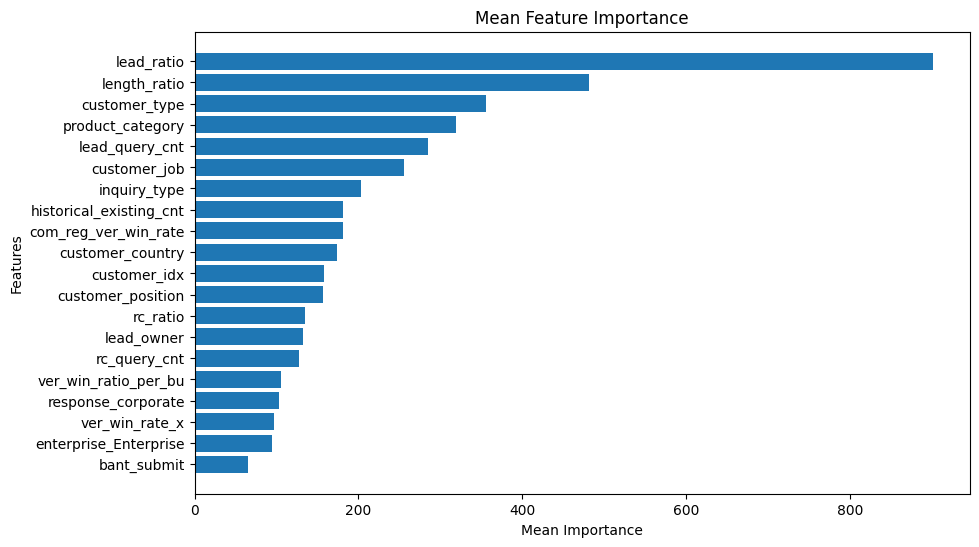

In [472]:
import numpy as np
import matplotlib.pyplot as plt

# 특징 중요도와 특징 이름을 정렬
top_features = 20
sorted_indices = np.argsort(-np.mean(feature_importance_list, axis=0))[::-1]
sorted_feature_names = [lgb_model.feature_name()[i] for i in sorted_indices][-top_features:]
sorted_mean_importance = np.mean(feature_importance_list, axis=0)[sorted_indices][-top_features:]

# 바 차트 그리기
plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names, sorted_mean_importance)
plt.xlabel('Mean Importance')
plt.ylabel('Features')
plt.title('Mean Feature Importance')
plt.show()

### 테스트 데이터 예측

In [473]:
# 예측에 필요한 데이터 분리
test_pred = np.where(oof_test_preds >= 0.3, 1, 0)

In [474]:
sum(test_pred) # True로 예측된 개수 1038

1876

## 4. 제출하기

### 제출 파일 작성

In [475]:
df_test["is_converted"] = test_pred

In [477]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("/content/drive/MyDrive/LGaimers/submission.csv")
df_sub["is_converted"]=df_test["is_converted"]

# 제출 파일 저장
df_sub.to_csv("/content/drive/MyDrive/LGaimers/submission_youngho0212.csv", index=False)

**우측 상단의 제출 버튼을 클릭해 결과를 확인하세요**